In [1]:
import numpy as np
from matplotlib import pyplot as plt

import math

import torch
from torch import nn

import pandas_datareader as pdr
from sklearn.metrics import mean_squared_error
from rnn import RNN
from lstm import LSTM

## Data Preprocessing

In [2]:
GOOG_data = pdr.DataReader('GOOG','stooq').reset_index()

In [3]:
interval = 10

### Train set

In [4]:
GOOG_2023 = GOOG_data[(GOOG_data['Date'] >= '2023-01-01') & (GOOG_data['Date'] <= '2023-12-31')]
GOOG_2023_st = GOOG_2023['Close'].diff().dropna().reset_index()['Close']

X_train = torch.tensor([GOOG_2023_st.tolist()[i:i+interval] for i in range(len(GOOG_2023_st.tolist()))][:-interval])
y_train = torch.Tensor(GOOG_2023_st.shift(-interval).dropna().reset_index()['Close'])
X_train.shape, len(y_train)

(torch.Size([239, 10]), 239)

### Test set

In [5]:
GOOG_2024 = GOOG_data[(GOOG_data['Date'] >= '2024-01-01') & (GOOG_data['Date'] <= '2024-12-31')]
GOOG_2024_st = GOOG_2024['Close'].diff().dropna().reset_index()['Close']

X_test = torch.tensor([GOOG_2024_st.tolist()[i:i+interval] for i in range(len(GOOG_2024_st.tolist()))][:-interval])
y_test = torch.Tensor(GOOG_2024_st.shift(-interval).dropna().reset_index()['Close'])
X_test.shape, len(y_test)

(torch.Size([126, 10]), 126)

## RNN

In [6]:
rnn = RNN(interval, 64, 1)
hidd_tensor = rnn.init_hidden()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.01)

c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def train(x):
  h = rnn.init_hidden()
  for _ in range(1000):
    for i in range(x.size()[0]):
      out, h = rnn(x[i], h)

    loss = criterion(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return out, loss.item()

out, loss = train(X_train)
print(loss)

c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([239])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


6.0311360359191895


### Testing

In [8]:
pred = []
h = rnn.init_hidden()
for i in range(X_test.size()[0]):
    out, h = rnn.forward(X_test[i], h)
    pred.append(out.item())

math.sqrt(mean_squared_error(y_test, pred))

2.894782581446006

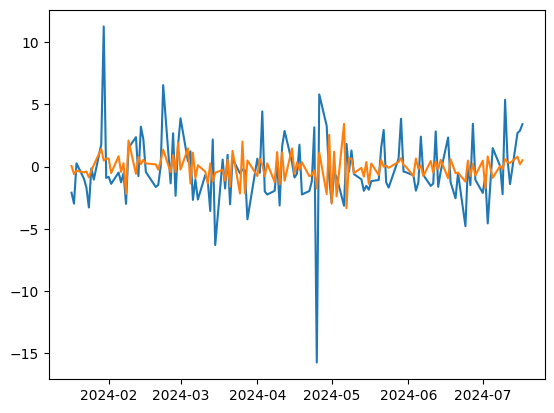

In [9]:
plt.plot(GOOG_2024['Date'][1:-interval], GOOG_2024_st[:-interval])
plt.plot(GOOG_2024['Date'][1:-interval], pred)

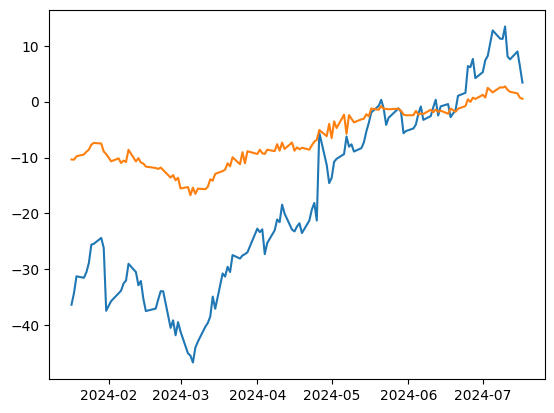

In [10]:
plt.plot(GOOG_2024['Date'][1:-interval], np.cumsum(GOOG_2024_st[:-interval]))
plt.plot(GOOG_2024['Date'][1:-interval], np.cumsum(pred))

## LSTM

In [11]:
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
num_epochs = 1000

In [12]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
from time import time
num_epochs = 10
hist = np.zeros(num_epochs)
start_time = time()
lstm = []

for i in range(num_epochs):
    for data in X_train[:5]:
      y_train_pred = model(data.reshape(1, -1, 1))

      loss = criterion(y_train_pred, y_train)
      if (i%100 == 0):
        print("Epoch ", i, "MSE: ", loss.item())
      hist[i] = loss.item()

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

training_time = time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  5.197360515594482
Epoch  0 MSE:  5.197360515594482
Epoch  0 MSE:  5.197360038757324
Epoch  0 MSE:  5.197360515594482
Epoch  0 MSE:  5.197360992431641
Training time: 0.1706857681274414


c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([239])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
